<a href="https://colab.research.google.com/github/Jeetsmeats/Full-Scale-Autonomous-Driving/blob/main/Full_scale_Autonomous_Driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full-Scale Autonomous Driving: Simulations Based Comparison

## Subject: AI4Robotics (ELEN90095)
## Authors:
- Yusuf Berdan Güzel (1051639)
- Gunjeet Singh (1170248)

## Install Dependencies (Only on Google Colab)

In [ ]:
!pip install -q gymnasium stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 5.8 MB/s eta 0:00:00


In [ ]:
!git clone https://gitlab.unimelb.edu.au/ai4r/ai4r-gym.git

Cloning into 'ai4r-gym'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 194 (delta 64), reused 0 (delta 0), pack-reused 64 (from 1)
Receiving objects: 100% (194/194), 159.60 KiB | 249.00 KiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
%cd ai4r-gym

/content/ai4r-gym


## Library Imports:

In [ ]:
import ai4rgym
from ai4rgym.envs.road import Road
import gymnasium as gym
import numpy as np
import random
from stable_baselines3 import PPO, SAC, DDPG
from utils import ensure_dir, ensure_dirs, eval_model
import matplotlib.pyplot as plt

## Environment Settings:

In [ ]:
# SPECIFY THE VEHCILE PARAMETERS
bicycle_model_parameters = {
    "Lf" : 0.55*2.875,
    "Lr" : 0.45*2.875,
    "m"  : 2000.0,
    "Iz" : (1.0/12.0) * 2000.0 * (4.692**2+1.850**2),
    "Cm" : (1.0/100.0) * (1.0 * 400.0 * 9.0) / 0.2286,
    "Cd" : 0.5 * 0.24 * 2.2204 * 1.202,
    "delta_offset" : 0 * np.pi/180,
    "delta_request_max" : 45 * np.pi/180,
    "Ddelta_lower_limit" : -45 * np.pi/180,
    "Ddelta_upper_limit" :  45 * np.pi/180,
    "v_transition_min": 3.0,    # v_transition_min = 3.0 m/s
    "v_transition_max": 5.0,    # v_transition_max = 5.0 m/s
    "body_len_f" : (0.55*2.875) * 1.5,
    "body_len_r" : (0.45*2.875) * 1.5,
    "body_width" : 2.50,
}

# SPECIFY THE ROAD

# This road will not be used for training / evaluation
# this is just kept in place to initialize the environment
road_elements_list = [
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":1/800.0, "angle_in_degrees":15.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":-1/400.0, "angle_in_degrees":30.0},
    {"type":"straight", "length":100.0},
]

# SPECIFY THE NUMERICAL INTEGRATION DETAILS
numerical_integration_parameters = {
    "method" : "rk4",
    "Ts" : 0.05,
    "num_steps_per_Ts" : 1,
}

# SPECIFY THE INITIAL STATE DISTRIBUTION

py_init_min = -1.0
py_init_max =  1.0

v_init_min_in_kmh = 55.0
v_init_max_in_kmh = 65.0

py_init_min = -1.0
py_init_max =  1.0

v_init_min_in_kmh = 55.0
v_init_max_in_kmh = 65.0

initial_state_bounds = {
    "px_init_min" : 0.0,
    "px_init_max" : 0.0,
    "py_init_min" : py_init_min,
    "py_init_max" : py_init_max,
    "theta_init_min" : 0.0,
    "theta_init_max" : 0.0,
    "vx_init_min" : v_init_min_in_kmh * (1.0/3.6),
    "vx_init_max" : v_init_max_in_kmh * (1.0/3.6),
    "vy_init_min" : 0.0,
    "vy_init_max" : 0.0,
    "omega_init_min" : 0.0,
    "omega_init_max" : 0.0,
    "delta_init_min" : 0.0,
    "delta_init_max" : 0.0,
}

# SPECIFY THE TERMINATION PARAMETERS
termination_parameters = {
    "speed_lower_bound"  :  0.0,
    "speed_upper_bound"  :  (200.0/3.6),
    "distance_to_closest_point_upper_bound"  :  20.0,
    "reward_speed_lower_bound"  :  0.0,
    "reward_speed_upper_bound"  :  0.0,
    "reward_distance_to_closest_point_upper_bound"  :  0.0,
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting Observations:

In [ ]:
# SPECIFY THE OBSERVATION PARAMETERS
observation_parameters = {
    "should_include_ground_truth_px"                       :  "info",
    "should_include_ground_truth_py"                       :  "info",
    "should_include_ground_truth_theta"                    :  "info",
    "should_include_ground_truth_vx"                       :  "info",
    "should_include_ground_truth_vy"                       :  "info",
    "should_include_ground_truth_omega"                    :  "info",
    "should_include_ground_truth_delta"                    :  "info",
    "should_include_road_progress_at_closest_point"        :  "info",
    "should_include_vx_sensor"                             :  "info",
    "should_include_distance_to_closest_point"             :  "obs",
    "should_include_heading_angle_relative_to_line"        :  "obs",
    "should_include_heading_angular_rate_gyro"             :  "info",
    "should_include_closest_point_coords_in_body_frame"    :  "info",
    "should_include_look_ahead_line_coords_in_body_frame"  :  "info",
    "should_include_road_curvature_at_closest_point"       :  "info",
    "should_include_look_ahead_road_curvatures"            :  "info",

    "scaling_for_ground_truth_px"                       :  1.0,
    "scaling_for_ground_truth_py"                       :  1.0,
    "scaling_for_ground_truth_theta"                    :  1.0,
    "scaling_for_ground_truth_vx"                       :  1.0,
    "scaling_for_ground_truth_vy"                       :  1.0,
    "scaling_for_ground_truth_omega"                    :  1.0,
    "scaling_for_ground_truth_delta"                    :  1.0,
    "scaling_for_road_progress_at_closest_point"        :  1.0,
    "scaling_for_vx_sensor"                             :  1.0,
    "scaling_for_distance_to_closest_point"             :  1.0,
    "scaling_for_heading_angle_relative_to_line"        :  1.0,
    "scaling_for_heading_angular_rate_gyro"             :  1.0,
    "scaling_for_closest_point_coords_in_body_frame"    :  1.0,
    "scaling_for_look_ahead_line_coords_in_body_frame"  :  1.0,
    "scaling_for_road_curvature_at_closest_point"       :  1.0,
    "scaling_for_look_ahead_road_curvatures"            :  1.0,

    "vx_sensor_bias"    : 0.0,
    "vx_sensor_stddev"  : 0.1,

    "distance_to_closest_point_bias"    :  0.0,
    "distance_to_closest_point_stddev"  :  0.01,

    "heading_angle_relative_to_line_bias"    :  0.0,
    "heading_angle_relative_to_line_stddev"  :  0.01,

    "heading_angular_rate_gyro_bias"    :  0.0,
    "heading_angular_rate_gyro_stddev"  :  0.01,

    "closest_point_coords_in_body_frame_bias"    :  0.0,
    "closest_point_coords_in_body_frame_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_bias"    :  0.0,
    "look_ahead_line_coords_in_body_frame_stddev"  :  0.0,

    "road_curvature_at_closest_point_bias"    :  0.0,
    "road_curvature_at_closest_point_stddev"  :  0.0,

    "look_ahead_road_curvatures_bias"    :  0.0,
    "look_ahead_road_curvatures_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_distance"    :  100.0,
    "look_ahead_line_coords_in_body_frame_num_points"  :  10,
}

## Environment Creation:
- Reward Wrapper set up.
- Observation Wrapper set up.

In [ ]:
class RewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(RewardWrapper, self).__init__(env)

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)

        # Create your own reward here
        reward = reward

        return observation, reward, terminated, truncated, info


def create_env(road_elements_list):
    env = gym.make(
        "ai4rgym/autonomous_driving_env",
        render_mode=None,
        bicycle_model_parameters=bicycle_model_parameters,
        road_elements_list=road_elements_list,
        numerical_integration_parameters=numerical_integration_parameters,
        termination_parameters=termination_parameters,
        initial_state_bounds=initial_state_bounds,
        observation_parameters=observation_parameters,
    )

    # Set the integration method and time step
    Ts_sim = 0.05
    integration_method = "rk4"
    env.unwrapped.set_integration_method(integration_method)
    env.unwrapped.set_integration_Ts(Ts_sim)

    # Set the road condition
    env.unwrapped.set_road_condition(road_condition="wet")

    # Rescale actions and wrap the environment
    env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)
    env = RewardWrapper(env)
    return env

class ObservationWrapper(gym.Wrapper):
    def __init__(self, env):
        super(RewardWrapper, self).__init__(env)

## RTI-MPC Policy
update with code...

In [ ]:
# class MPC:


## Domain Randomization Wrapper:
- Designate a domain randomization wrapper for random generation of the terrain in training.



In [ ]:
class DomainRandomizationWrapper(gym.Wrapper):
    def __init__(self, env, road_randomization_params=None):
        super(DomainRandomizationWrapper, self).__init__(env)
        self.road_randomization_params = road_randomization_params

    def generate_random_road_elements_list(self):
        params = self.road_randomization_params or {}
        num_elements_range = params.get('num_elements_range', (2, 5))
        straight_length_range = params.get('straight_length_range', (50.0, 200.0))
        curvature_range = params.get('curvature_range', (-1/500.0, 1/500.0))
        angle_range = params.get('angle_range', (10.0, 60.0))

        road_elements = []
        num_elements = random.randint(*num_elements_range)

        for _ in range(num_elements):
            element_type = random.choice(['straight', 'curved'])
            if element_type == 'straight':
                length = random.uniform(*straight_length_range)
                road_elements.append({"type": "straight", "length": length})
            else:
                curvature = random.uniform(*curvature_range)
                angle = random.uniform(*angle_range)
                road_elements.append({
                    "type": "curved",
                    "curvature": curvature,
                    "angle_in_degrees": angle
                })
        return road_elements

    def reset(self, **kwargs):
        # Generate a new random road
        self.unwrapped.road_elements_list = self.generate_random_road_elements_list()
        self.unwrapped.road = Road(epsilon_c=(1/10000), road_elements_list=self.unwrapped.road_elements_list)
        self.unwrapped.total_road_length = self.unwrapped.road.get_total_length()
        self.unwrapped.total_road_length_for_termination = max(self.unwrapped.total_road_length - 0.1, 0.9999 * self.unwrapped.total_road_length)
        # Call the original reset method
        return self.env.reset(**kwargs)

### Visualizing Random Roads:

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_matplotlib_init_figure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_matplotlib_init_figure` for environment variables or `env.get_wrapper_attr('render_matplotlib_init_figure')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_matplotlib_plot_road to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_matplotlib_plot_road` for environment variables or `env.get_wrapper_attr('render_matplotlib_plot_road')` that will search the reminding wrappers.
  logger.warn(


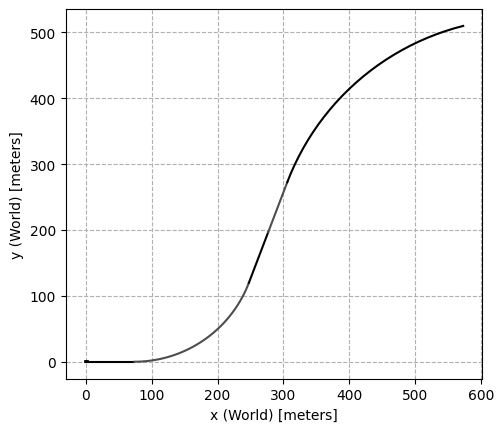

In [ ]:

# Sample
road_randomization_params = {
    'num_elements_range': (4, 8),             # More road elements
    'straight_length_range': (50.0, 100.0),   # Shorter straight segments
    'curvature_range': (-1/100.0, 1/100.0),   # Tighter curves
    'angle_range': (30.0, 70.0)               # More aggressive curves with wider angle range
}

random_env = create_env(road_elements_list = road_elements_list, )
random_env = DomainRandomizationWrapper(random_env, road_randomization_params=road_randomization_params)

# Reset the random env - this will create a new random road
random_env.reset()

# Render the road
random_env.render_matplotlib_init_figure()
random_env.render_matplotlib_plot_road()
plt.show()

## Setting up Training/Evaluation Environments:

In [ ]:
road_randomization_params = {
    "num_elements_range": (0, 0),
    "straight_length_range": (0.0, 0.0),
    "curvature_range": (-0/100.0, 0/100.0),
    "angle_range": (0.0, 0.0),
}

# Create the training environment with domain randomization
train_env = create_env(road_elements_list=road_elements_list)  # Road elements will be randomized
train_env = DomainRandomizationWrapper(train_env, road_randomization_params = road_randomization_params)
train_env = RewardWrapper(train_env)

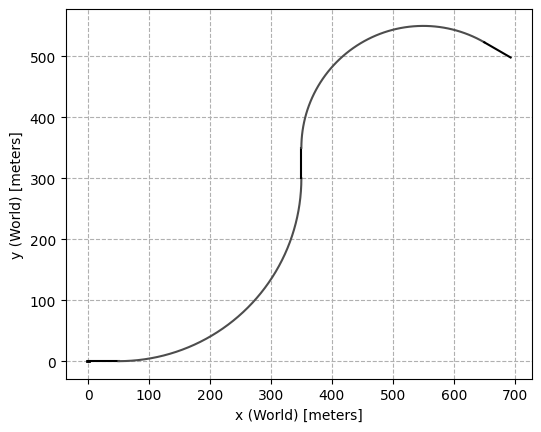

In [ ]:
# Define a fixed, difficult road for evaluation
road_elements_list_difficult = [
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": 1/300.0, "angle_in_degrees": 90.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": -1/200.0, "angle_in_degrees": 120.0},
    {"type": "straight", "length": 50.0},
]

# Create the evaluation environment with the fixed difficult road
eval_env = create_env(road_elements_list_difficult)

# Render the road
eval_env.render_matplotlib_init_figure()
eval_env.render_matplotlib_plot_road()
plt.show()

## Model Definition and Training:

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/PPO_dr_wet_long_0
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 116       |
|    ep_rew_mean     | -2.11e+07 |
| time/              |           |
|    fps             | 571       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 107           |
|    ep_rew_mean          | -1.65e+07     |
| time/                   |               |
|    fps                  | 476           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.2133387e-07 |
|    clip_fraction        | 0         

/content/ai4r-gym/utils.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots()


Logging to logs/PPO_dr_wet_long_0
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 98.2      |
|    ep_rew_mean     | -1.28e+07 |
| time/              |           |
|    fps             | 571       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 309248    |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 99.2          |
|    ep_rew_mean          | -1.27e+07     |
| time/                   |               |
|    fps                  | 470           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 311296        |
| train/                  |               |
|    approx_kl            | 1.2922101e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.84         |


KeyboardInterrupt: 

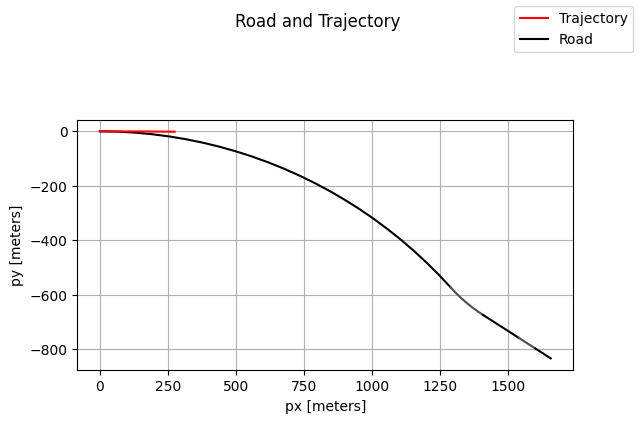

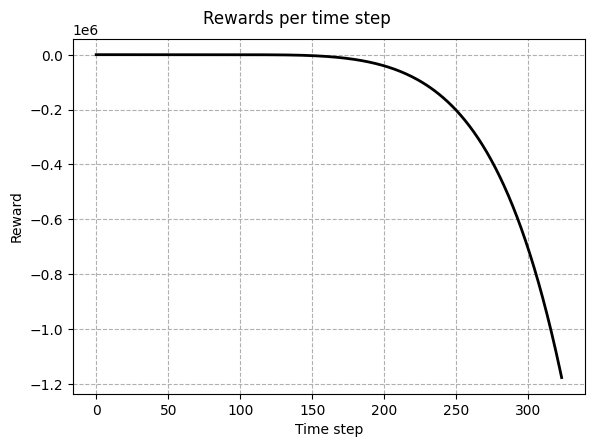

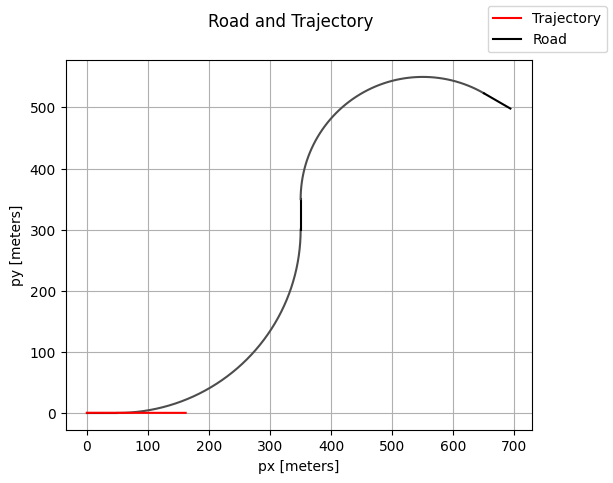

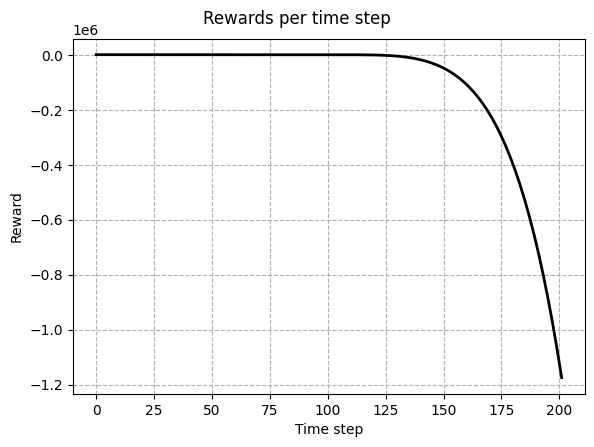

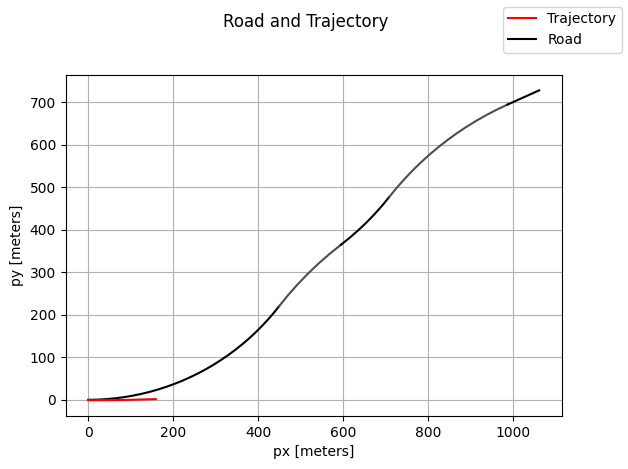

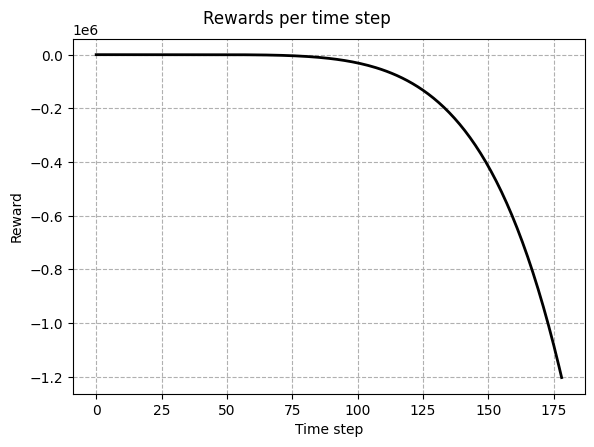

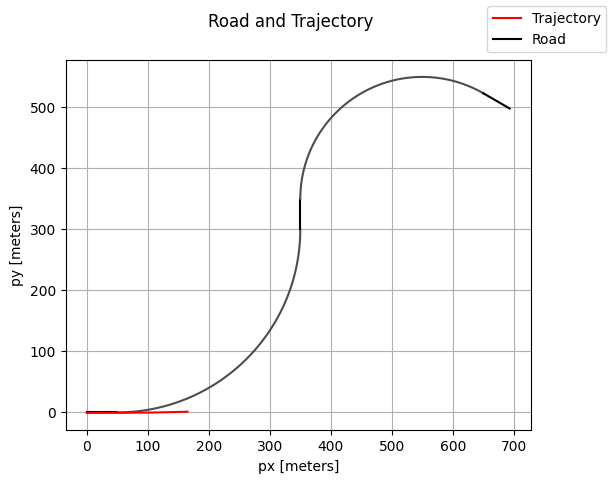

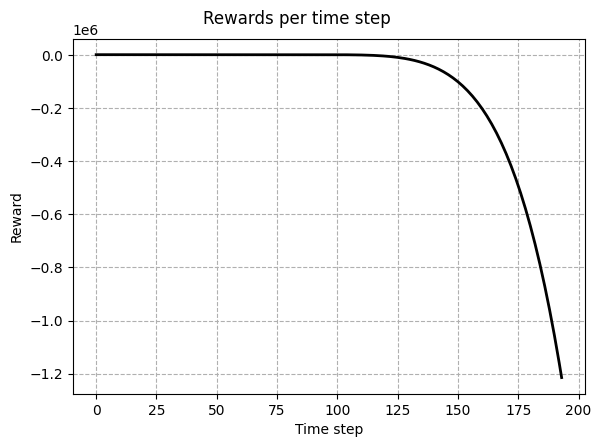

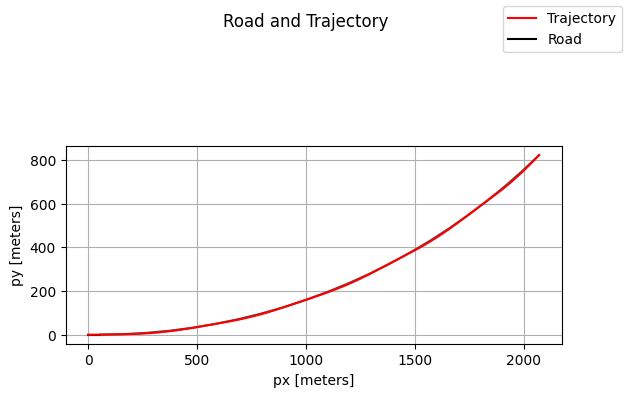

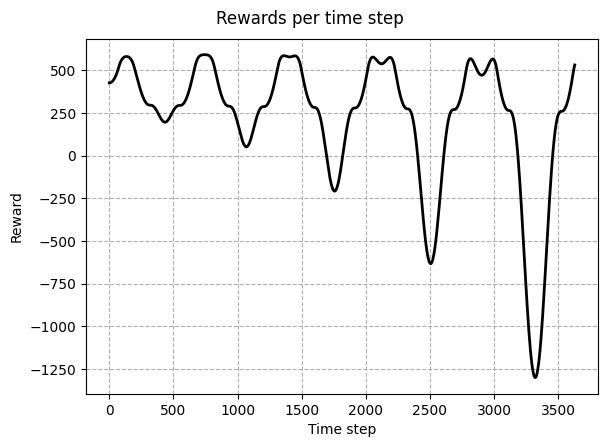

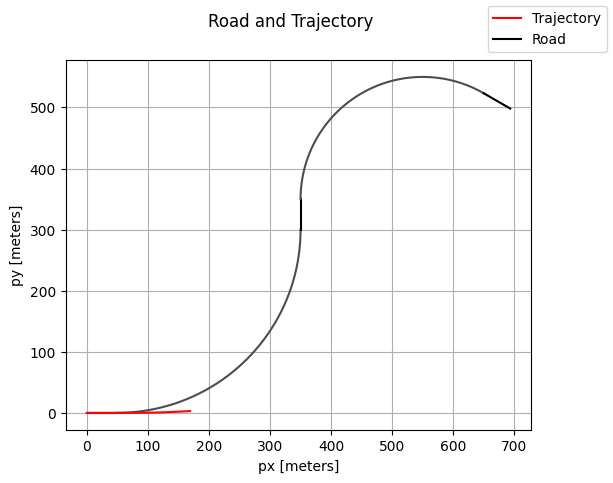

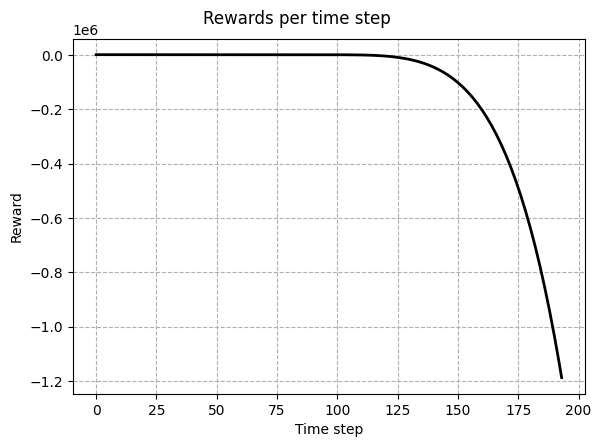

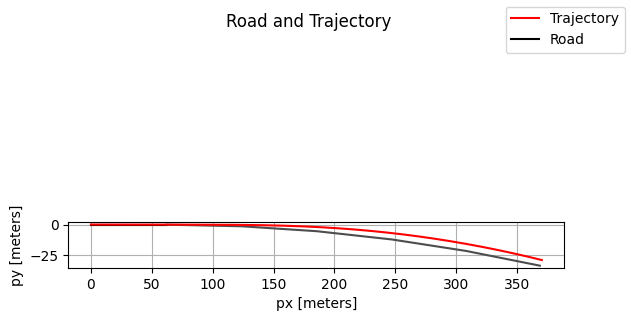

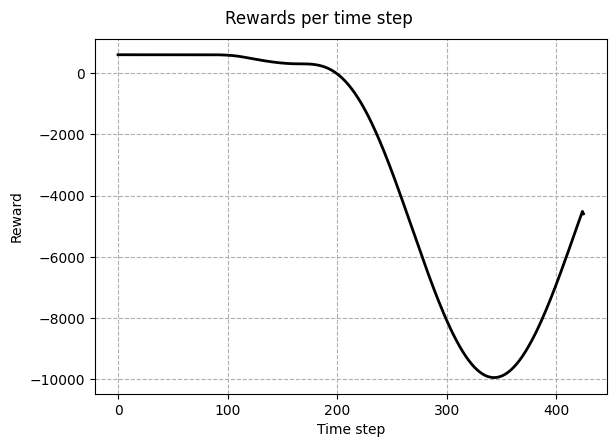

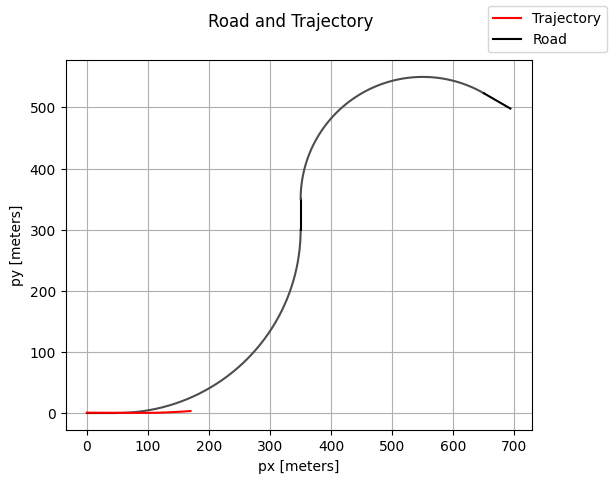

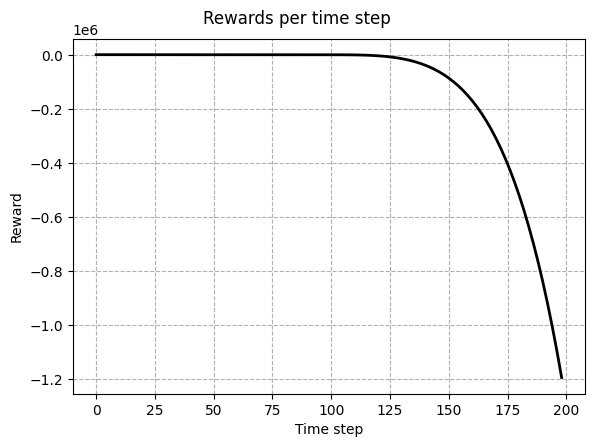

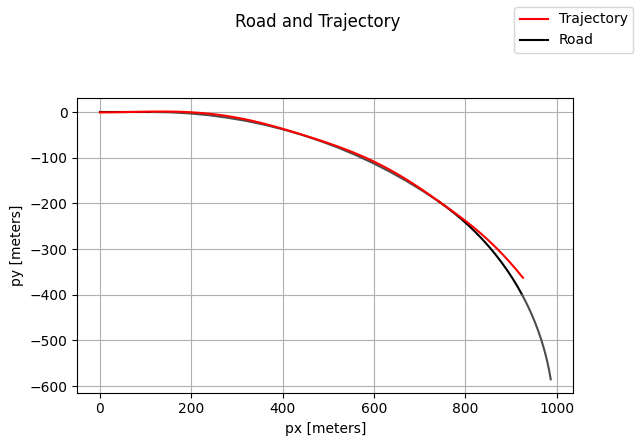

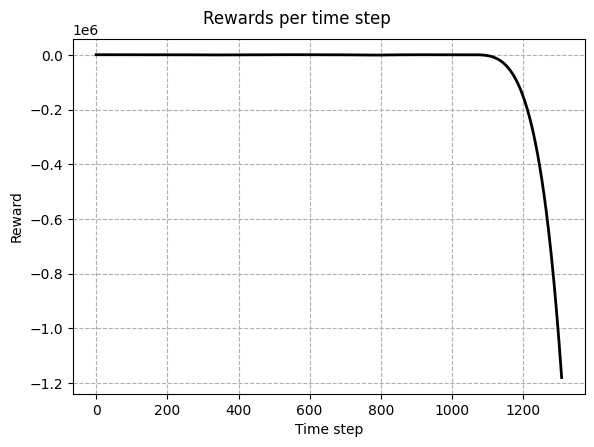

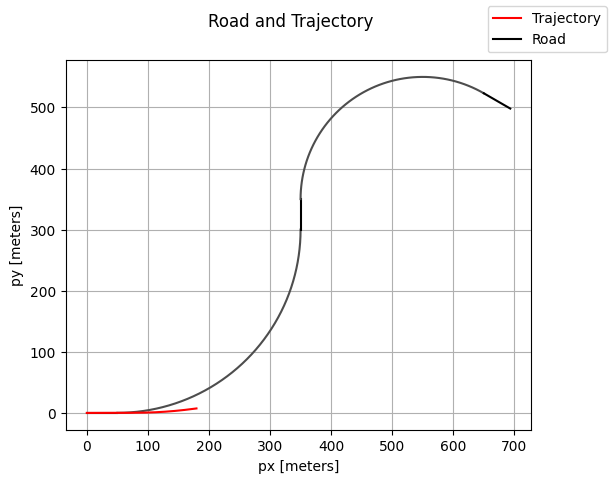

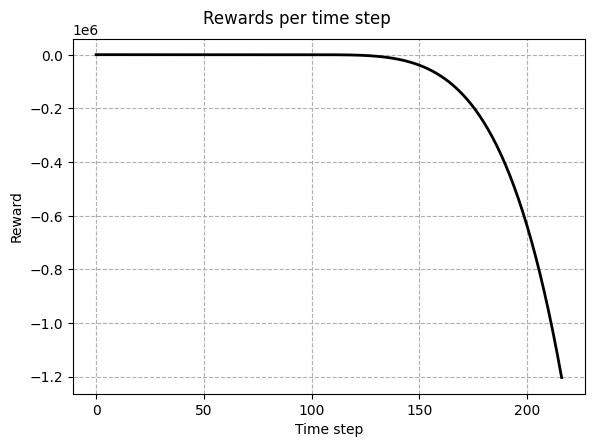

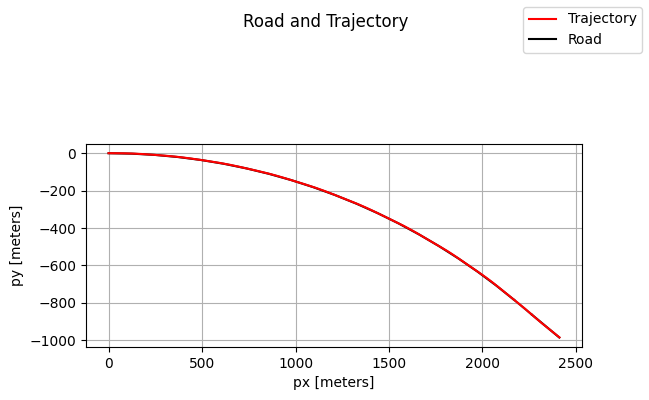

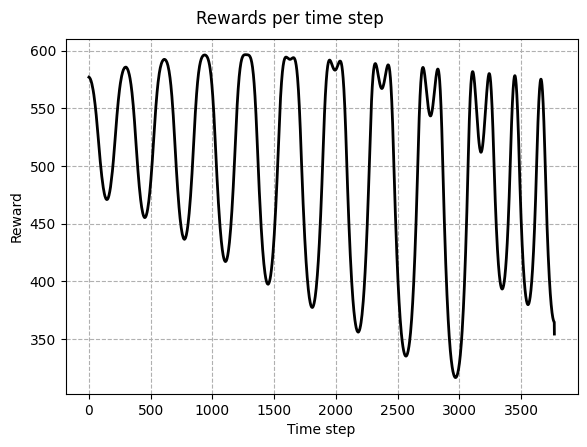

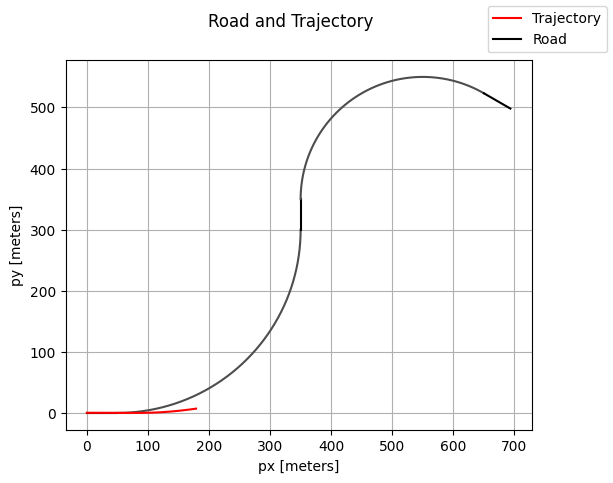

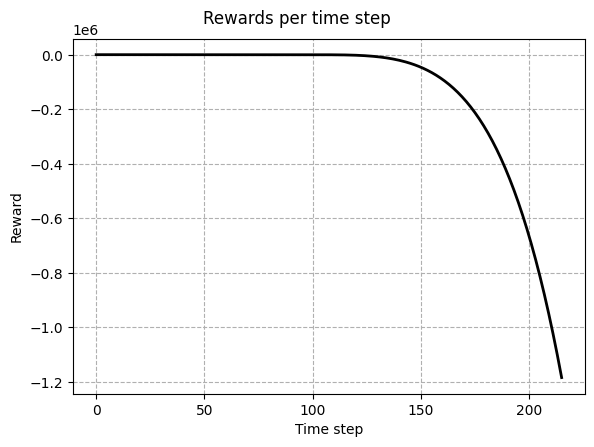

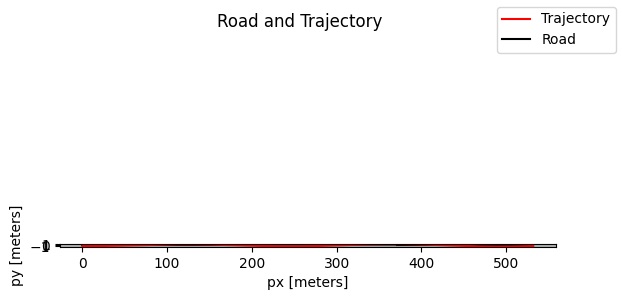

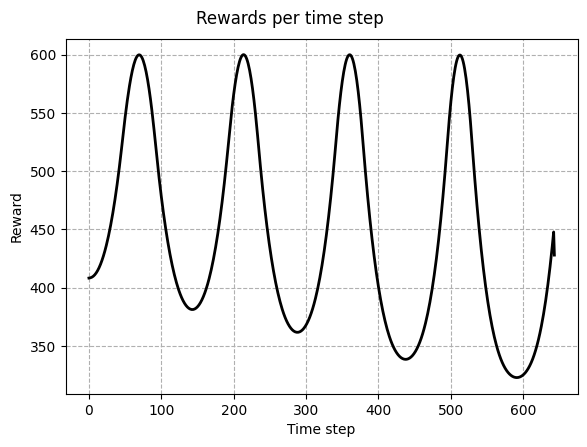

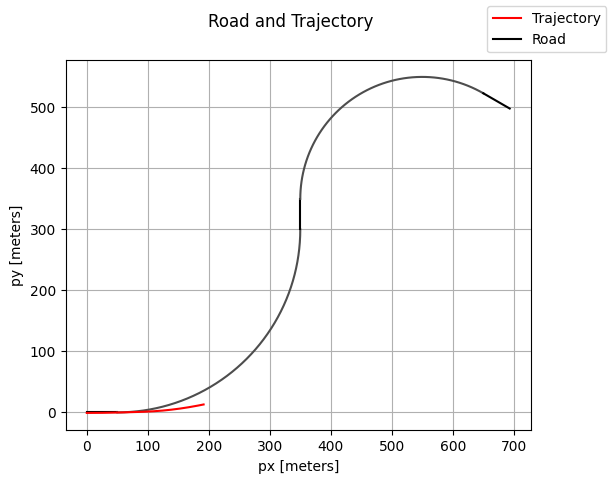

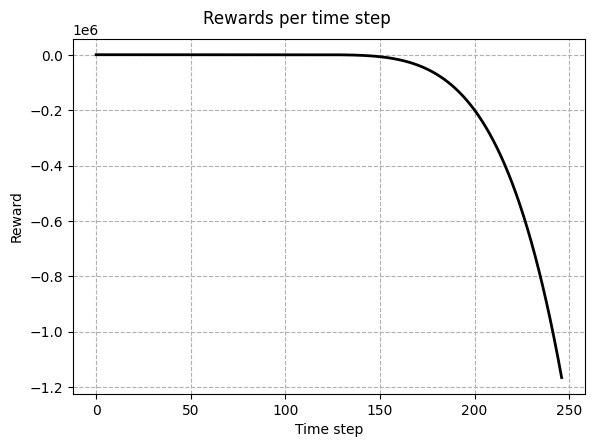

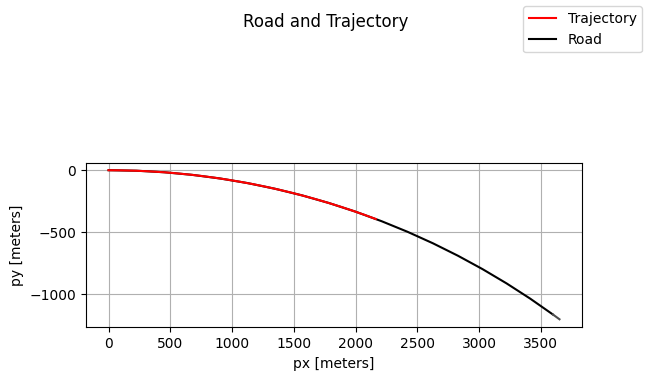

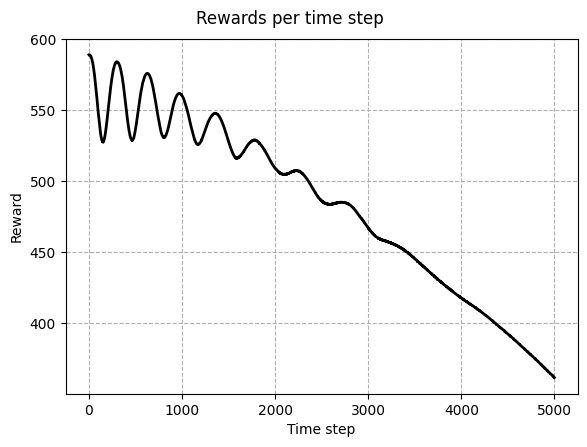

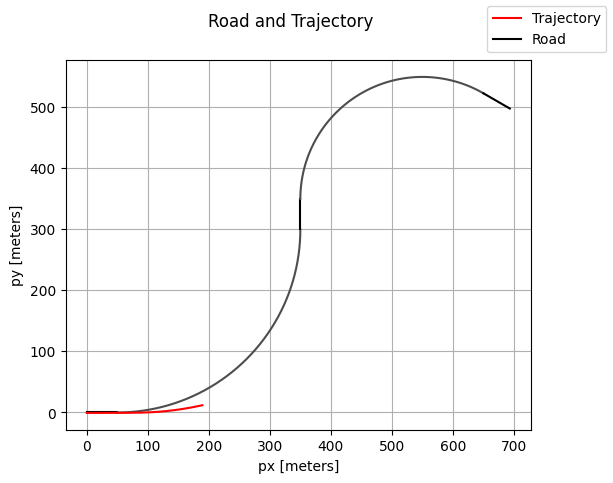

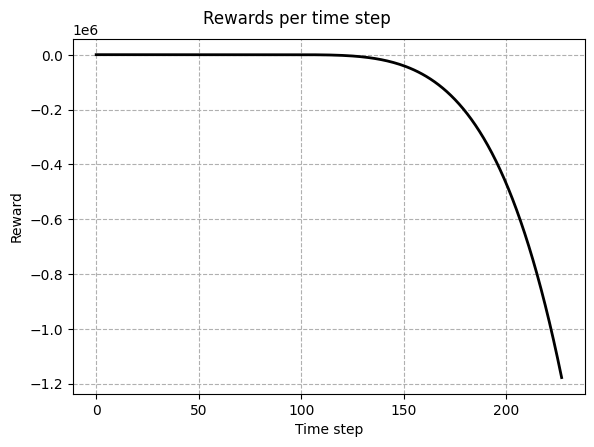

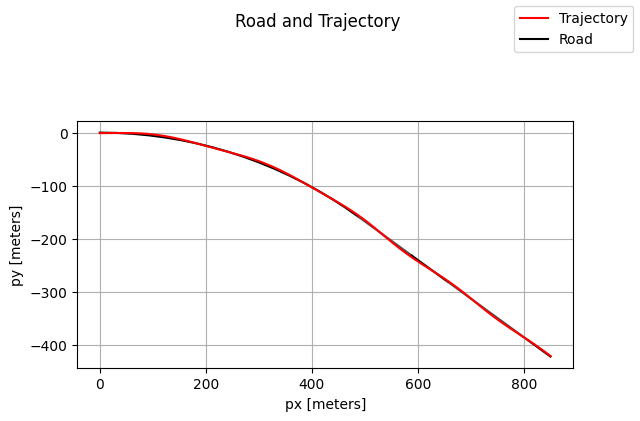

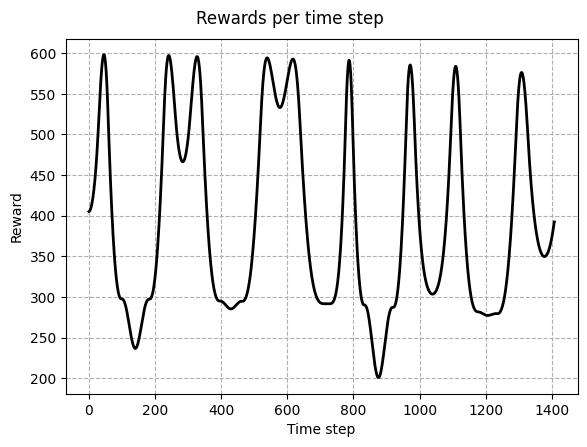

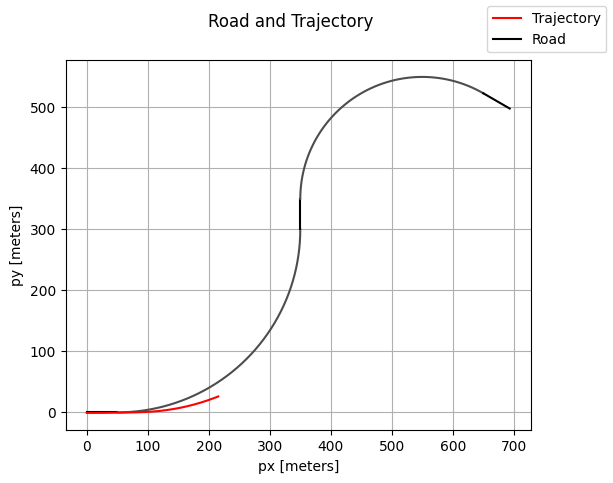

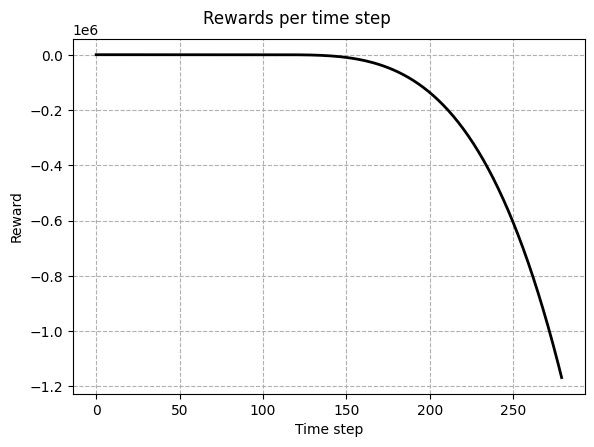

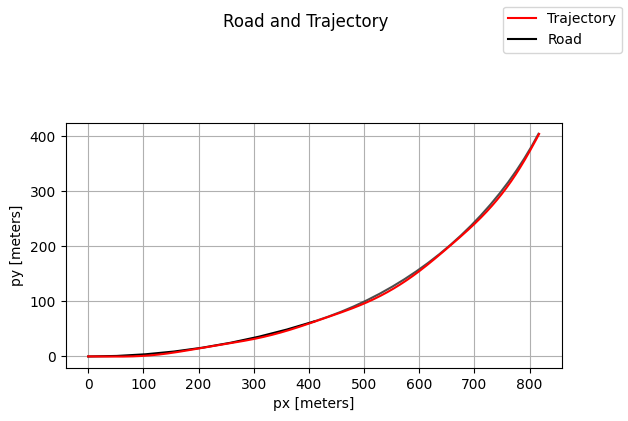

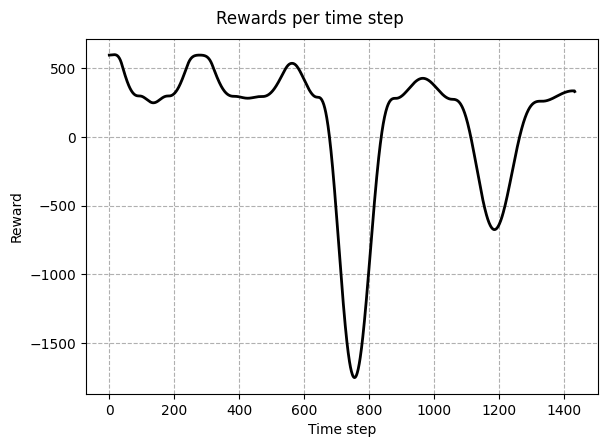

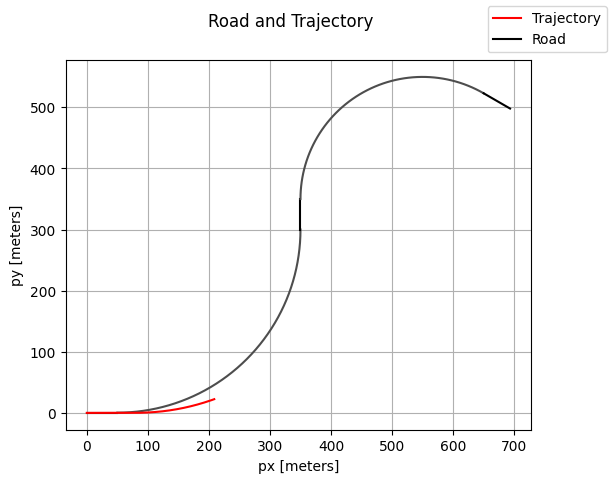

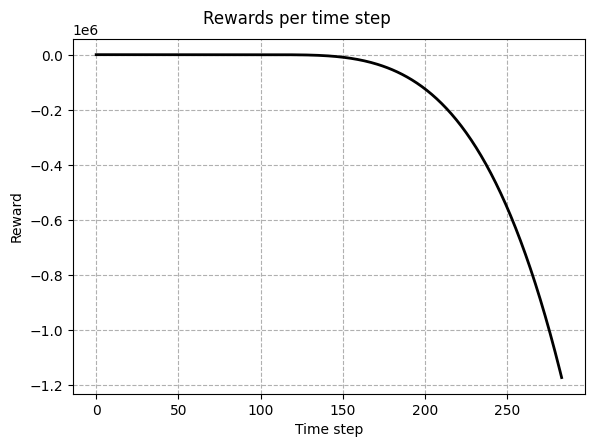

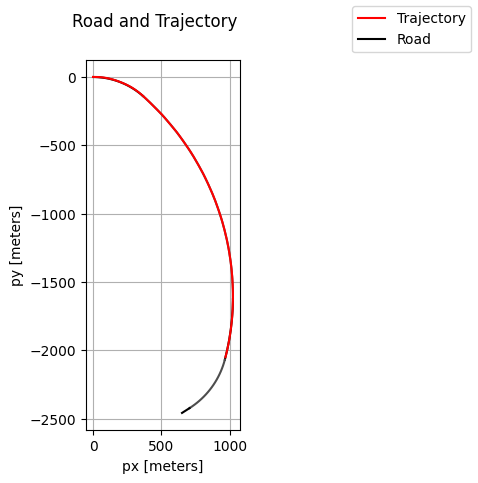

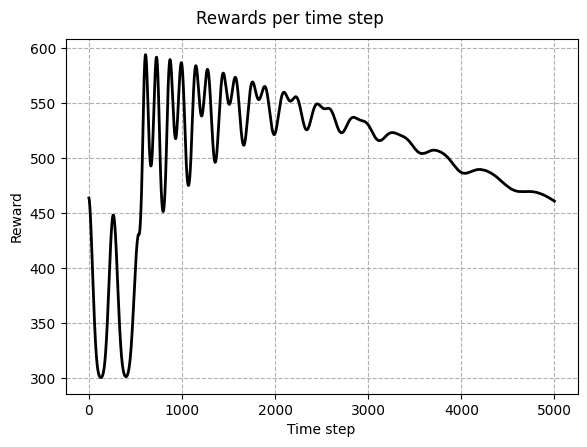

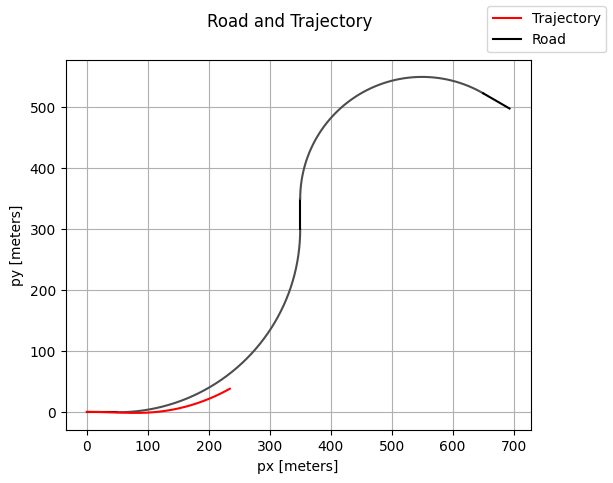

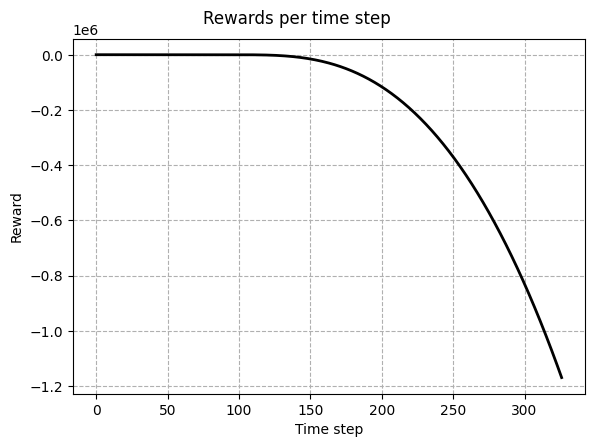

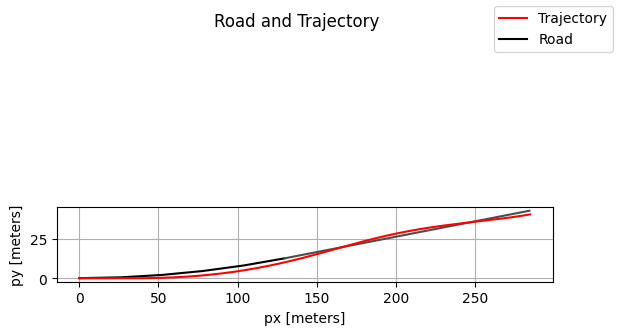

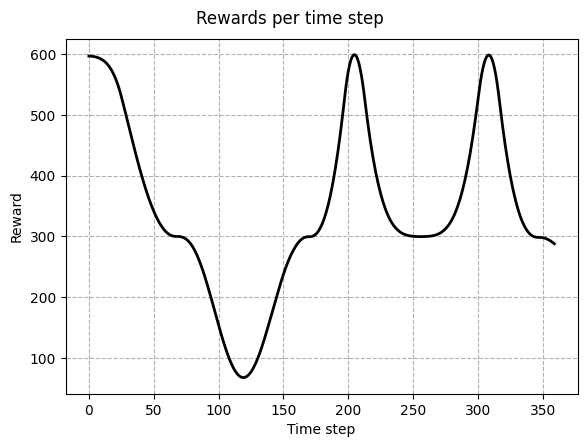

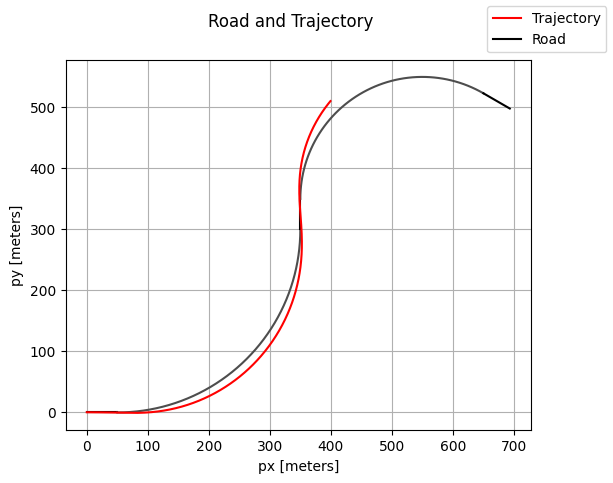

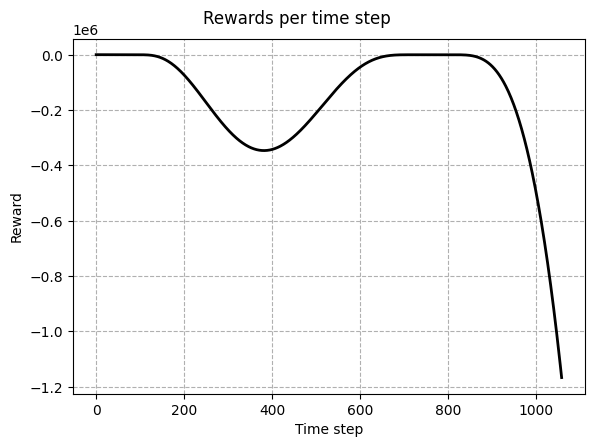

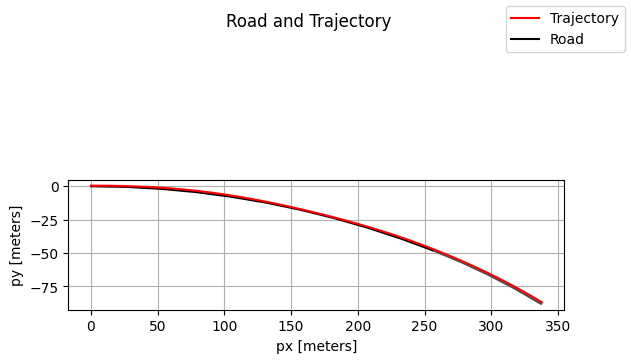

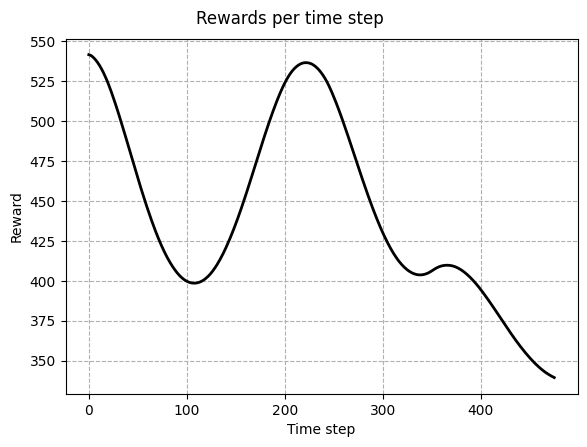

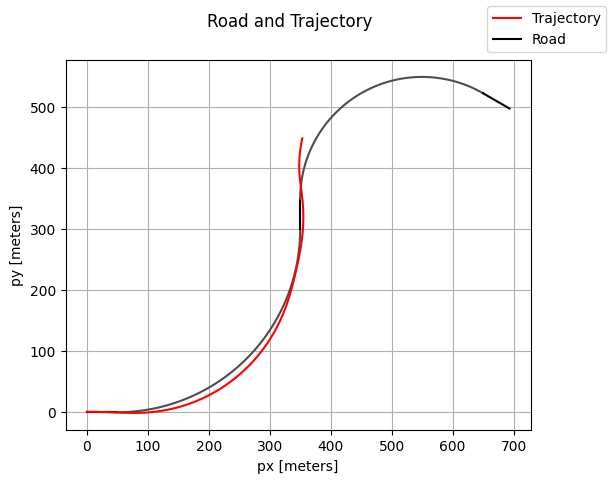

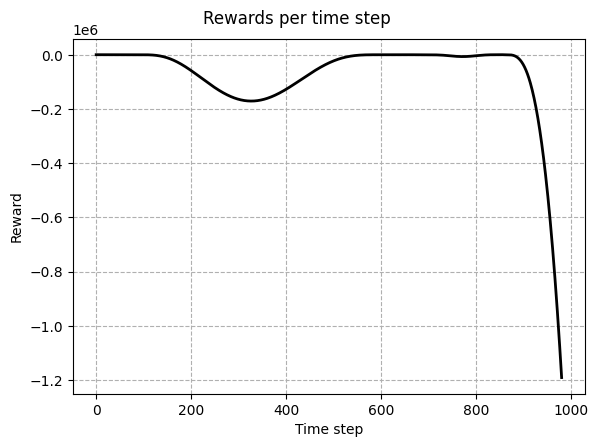

In [ ]:
from stable_baselines3 import PPO, SAC, DDPG

model_name = "PPO_dr_wet_long"

TIMESTEPS_PER_EPOCH = 50000
EPOCHS = 20

logdir = "logs"
models_dir = f"models/{model_name}"
figs_dir_train = f"models/{model_name}/figs_train"
figs_dir_test = f"models/{model_name}/figs_test"

ensure_dirs([logdir, models_dir, figs_dir_train, figs_dir_test])

model = PPO("MultiInputPolicy", train_env, verbose = 1, tensorboard_log=logdir)

for i in range(1, EPOCHS+1):
    model.learn(
        total_timesteps=TIMESTEPS_PER_EPOCH,
        reset_num_timesteps=False,
        tb_log_name=f"{model_name}"
    )
    model.save(f"{models_dir}/{TIMESTEPS_PER_EPOCH * i}")
    # Evaluate on the most recent training road
    eval_model(train_env, model, figs_dir_train, TIMESTEPS_PER_EPOCH * i)
    # Evaluate on evaluation road
    eval_model(eval_env, model, figs_dir_test, TIMESTEPS_PER_EPOCH * i)

## Evaluating the RL Policy:

### Load an RL model from the training loop:

In [ ]:
model_name = "PPO_dr_long"
model_idx = 950000

path_for_saving_figures = f"models/{model_name}/eval"
ensure_dir(path_for_saving_figures)

### Put the RL model into a policy class with a 'standardize' interface

In [ ]:
from policies.rl_policy import RLPolicy

# Put the RL model into a policy class
rl_policy = RLPolicy(model)

### Perform One simulation of the policy, plot the time series results:

In [ ]:
# Import the function for simulating the autonomous driving environment
from evaluation.evaluation_for_autonomous_driving import simulate_policy
from evaluation.evaluation_for_autonomous_driving import plot_results_from_time_series_dict

# Specify the length of the simulation in time steps
N_sim = 5000

# Specify the seed for when the simulate function resets the random number generator
sim_seed = 1;

# Call the function for simulating a given RL model
sim_time_series_dict = simulate_policy(eval_env, N_sim, rl_policy, seed=sim_seed, verbose=1)

# Call the plotting function
file_name_suffix = "example"
plot_details_list = plot_results_from_time_series_dict(eval_env, sim_time_series_dict, path_for_saving_figures, file_name_suffix, should_plot_reward=True)

### Animate the time series results:

In [ ]:
def animate_from_sim_time_series_dict(sim_time_series_dict, Ts, path_for_saving_figures):
    # Extract the necessary trajectory information from the "sim_time_series_dict"
    px_traj    = sim_time_series_dict["px"]
    py_traj    = sim_time_series_dict["py"]
    theta_traj = sim_time_series_dict["theta"]
    delta_traj = sim_time_series_dict["delta"]
    # Call the environments function to create the simulation
    ani = eval_env.unwrapped.render_matplotlib_animation_of_trajectory(px_traj, py_traj, theta_traj, delta_traj, Ts, traj_increment=3)
    # Save the animation
    ani.save(f"{path_for_saving_figures}/trajectory_animation.gif")
    print(f'Saved animation at {path_for_saving_figures}/trajectory_animation.gif')
    # Return the animation object
    return ani

In [ ]:
# Call the animation functoin
ani = animate_from_sim_time_series_dict(sim_time_series_dict, numerical_integration_parameters["Ts"], path_for_saving_figures)
# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

## Performance Metrics:

### Define a performance Metrics Function per simulation time series:

In [ ]:
def compute_performance_metrics_from_time_series(sim_time_series_dict):
    # Compute the statistics of the distance to the line
    abs_dist_to_line_time_series = np.abs(sim_time_series_dict["distance_to_closest_point"])
    avg_dist  = np.nanmean(abs_dist_to_line_time_series)
    std_dist  = np.nanstd(abs_dist_to_line_time_series)
    max_dist  = np.nanmax(abs_dist_to_line_time_series)

    # Compute the statistics of the speed in the forward direction (i.e., the body-frame x-axis direction)
    speed_time_series = np.abs(sim_time_series_dict["vx"])
    avg_speed = np.nanmean(speed_time_series)
    std_speed = np.nanstd(speed_time_series)
    max_speed = np.nanmax(speed_time_series)
    min_speed = np.nanmin(speed_time_series)

    # Return the results
    return {
        "avg_dist"   :  avg_dist,
        "std_dist"   :  std_dist,
        "max_dist"   :  max_dist,
        "avg_speed"  :  avg_speed * 3.6,
        "std_speed"  :  std_speed * 3.6,
        "max_speed"  :  max_speed * 3.6,
        "min_speed"  :  min_speed * 3.6,
    }


### Run the Performance Metric Function for one simulation:

In [ ]:
# Simulate with the same seed as above to check that it gets the results consistent
sim_seed = 1;
sim_time_series_dict = simulate_policy(eval_env, N_sim, rl_policy, seed=sim_seed, verbose=1)

# Call the function for computing the performance metrics
pm_dict = compute_performance_metrics_from_time_series(sim_time_series_dict)

# Display the performance metric values
print("Performance Metric dictionary:")
print(pm_dict)